<a href="https://www.kaggle.com/kalilurrahman/unitedhealthgroup-stock-analysis-using-time-series?scriptVersionId=89684822" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
try:
    from pmdarima.arima import auto_arima
except:
    !pip install pmdarima
    from pmdarima.arima import auto_arima

    from sklearn.metrics import mean_squared_error, mean_absolute_error
import math


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

     |████████████████████████████████| 1.4 MB 894 kB/s            
/kaggle/input/united-healthcare-stock-data/UnitedHealthCare_stock_history.csv
/kaggle/input/united-healthcare-stock-data/UnitedHealthCare_stock_info.csv


# Welcome to Stock Forecasting using Time Series
**Forecasting** is perhaps the most common application of machine learning in the real world. Businesses forecast product demand, governments forecast economic and population growth, meteorologists forecast the weather. The understanding of things to come is a pressing need across science, government, and industry (not to mention our personal lives!), and practitioners in these fields are increasingly applying machine learning to address this need.

**Time series forecasting** is a broad field with a long history. This course focuses on the application of modern machine learning methods to time series data with the goal of producing the most accurate predictions. The lessons in this course were inspired by winning solutions from past Kaggle forecasting competitions but will be applicable whenever accurate forecasts are a priority.


## What is a Time Series?
The basic object of forecasting is the time series, which is a set of observations recorded over time. In forecasting applications, the observations are typically recorded with a regular frequency, like daily or monthly.

## We shall leverage the Kaggle Course - ## https://www.kaggle.com/learn/time-series and https://www.kaggle.com/nageshsingh/stock-market-forecasting-arima/notebook for this 

In [2]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
stock_data = pd.read_csv('../input/united-healthcare-stock-data/UnitedHealthCare_stock_history.csv',
                         sep=',', 
                         index_col='Date', 
                         parse_dates=['Date'], 
                         date_parser=dateparse).fillna(0)

In [3]:
stock_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1984-10-17,0.000000,0.122685,0.119455,0.119455,9868800,0.0,0.0
1984-10-18,0.000000,0.129141,0.122685,0.122685,5324800,0.0,0.0
1984-10-19,0.000000,0.122685,0.119455,0.119455,3043200,0.0,0.0
1984-10-22,0.000000,0.122685,0.119455,0.119455,2326400,0.0,0.0
1984-10-23,0.000000,0.119456,0.116227,0.116227,787200,0.0,0.0
...,...,...,...,...,...,...,...
2022-02-03,498.649994,500.179993,483.570007,488.769989,4370900,0.0,0.0
2022-02-04,481.750000,489.630005,480.190002,483.170013,3066400,0.0,0.0
2022-02-07,484.910004,487.260010,481.299988,483.700012,2937200,0.0,0.0


In [4]:
import numpy as np

stock_data['Time'] = np.arange(len(stock_data.index))

stock_data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Time
Date,,,,,,,,
1984-10-17,0.0,0.122685,0.119455,0.119455,9868800,0.0,0.0,0
1984-10-18,0.0,0.129141,0.122685,0.122685,5324800,0.0,0.0,1
1984-10-19,0.0,0.122685,0.119455,0.119455,3043200,0.0,0.0,2
1984-10-22,0.0,0.122685,0.119455,0.119455,2326400,0.0,0.0,3
1984-10-23,0.0,0.119456,0.116227,0.116227,787200,0.0,0.0,4


In [5]:
format = '%Y-%m-%d %H:%M:%S'
stock_data['Date'] = pd.to_datetime(stock_data.index , format=format)
stock_data = stock_data.set_index(pd.DatetimeIndex(stock_data['Date']))

This series records the number of hardcover book sales at a retail store over 30 days. Notice that we have a single column of observations Hardcover with a time index Date.

### Linear Regression with Time Series
For the first part of this course, we'll use the linear regression algorithm to construct forecasting models. Linear regression is widely used in practice and adapts naturally to even complex forecasting tasks.

The linear regression algorithm learns how to make a weighted sum from its input features. For two features, we would have:

> target = weight_1 * feature_1 + weight_2 * feature_2 + bias

During training, the regression algorithm learns values for the parameters weight_1, weight_2, and bias that best fit the target. (This algorithm is often called ordinary least squares since it chooses values that minimize the squared error between the target and the predictions.) The weights are also called regression coefficients and the bias is also called the intercept because it tells you where the graph of this function crosses the y-axis.

### Time-step features
There are two kinds of features unique to time series: time-step features and lag features.

Time-step features are features we can derive directly from the time index. The most basic time-step feature is the time dummy, which counts off time steps in the series from beginning to end.

Linear regression with the time dummy produces the model:

>> target = weight * time + bias

The time dummy then lets us fit curves to time series in a time plot, where Time forms the x-axis.

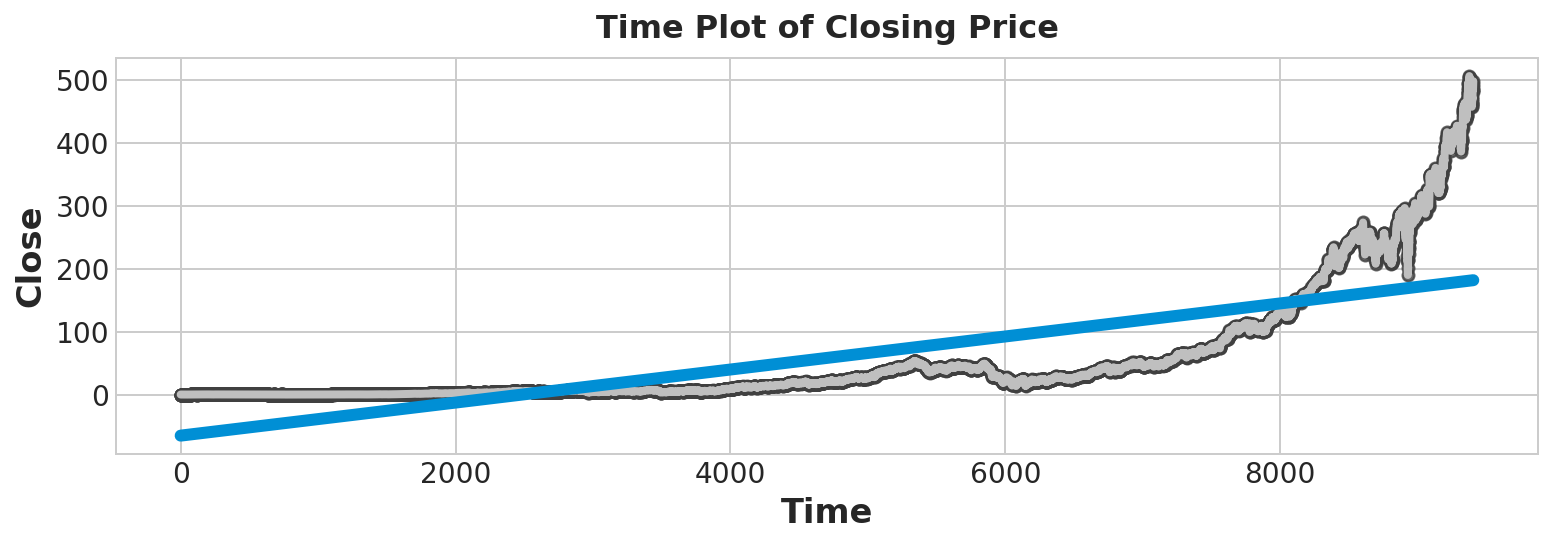

In [6]:

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
%config InlineBackend.figure_format = 'retina'

fig, ax = plt.subplots()
ax.plot('Time', 'Close', data=stock_data, color='0.75')
ax = sns.regplot(x='Time', y='Close', data=stock_data, ci=None, scatter_kws=dict(color='0.25'))
ax.set_title('Time Plot of Closing Price');

In [7]:
stock_data['Lag_1'] = stock_data['Close'].shift(1)
#stock_data = stock_data.reindex(columns=['Close', 'Lag_1'])

stock_data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Time,Date,Lag_1
Date,,,,,,,,,,
1984-10-17,0.0,0.122685,0.119455,0.119455,9868800,0.0,0.0,0,1984-10-17,NaN
1984-10-18,0.0,0.129141,0.122685,0.122685,5324800,0.0,0.0,1,1984-10-18,0.119455
1984-10-19,0.0,0.122685,0.119455,0.119455,3043200,0.0,0.0,2,1984-10-19,0.122685
1984-10-22,0.0,0.122685,0.119455,0.119455,2326400,0.0,0.0,3,1984-10-22,0.119455
1984-10-23,0.0,0.119456,0.116227,0.116227,787200,0.0,0.0,4,1984-10-23,0.119455


Linear regression with a lag feature produces the model:

> target = weight * lag + bias

So lag features let us fit curves to lag plots where each observation in a series is plotted against the previous observation.

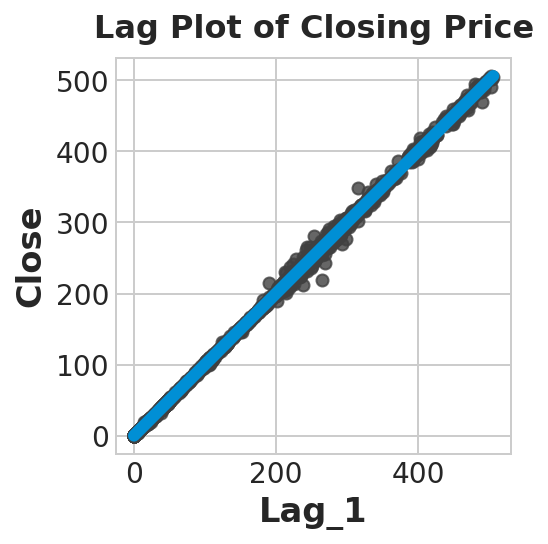

In [8]:
fig, ax = plt.subplots()
ax = sns.regplot(x='Lag_1', y='Close', data=stock_data, ci=None, scatter_kws=dict(color='0.25'))
ax.set_aspect('equal')
ax.set_title('Lag Plot of Closing Price');

In [9]:
from sklearn.linear_model import LinearRegression

# Training data
X = stock_data.loc[:, ['Time']]  # features
y = stock_data.loc[:, 'Close']  # target

# Train the model
model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X), index=X.index)

In [10]:
from pathlib import Path
from warnings import simplefilter

simplefilter("ignore")  # ignore warnings to clean up output cells

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

Text(0.5, 1.0, 'Time Plot of Closing Price')

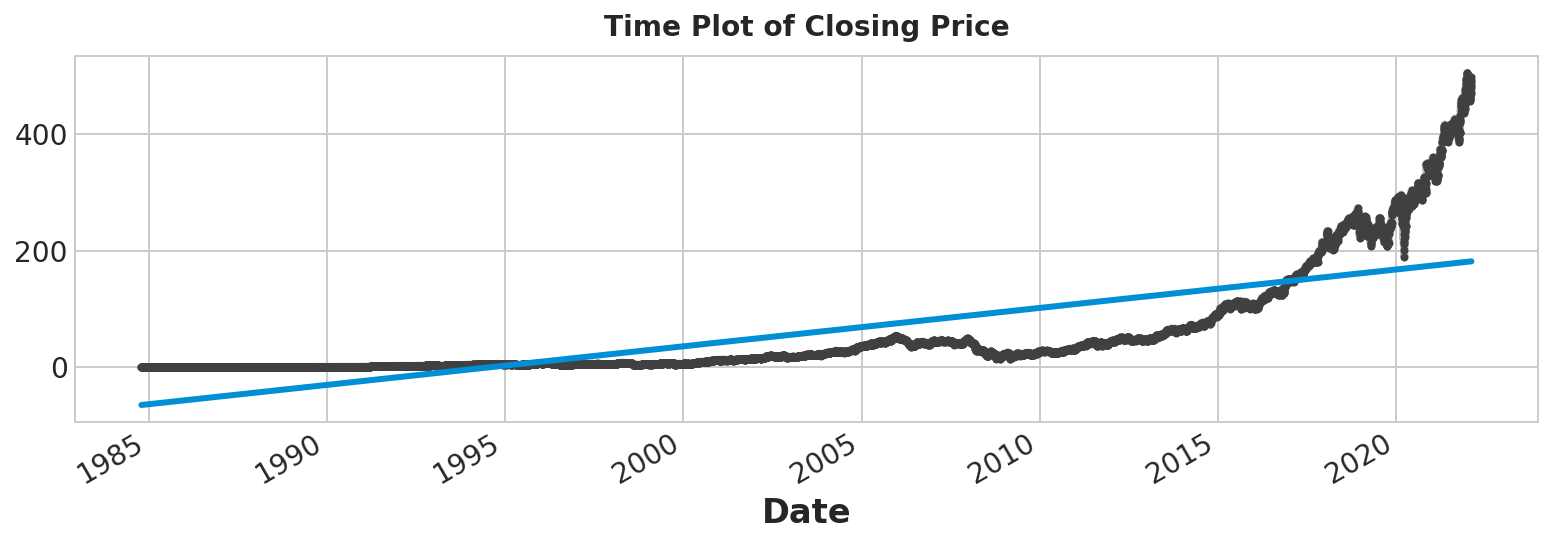

In [11]:
ax = y.plot(**plot_params)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of Closing Price')

<AxesSubplot:title={'center':'Tunnel Traffic - 365-Day Moving Average'}, xlabel='Date'>

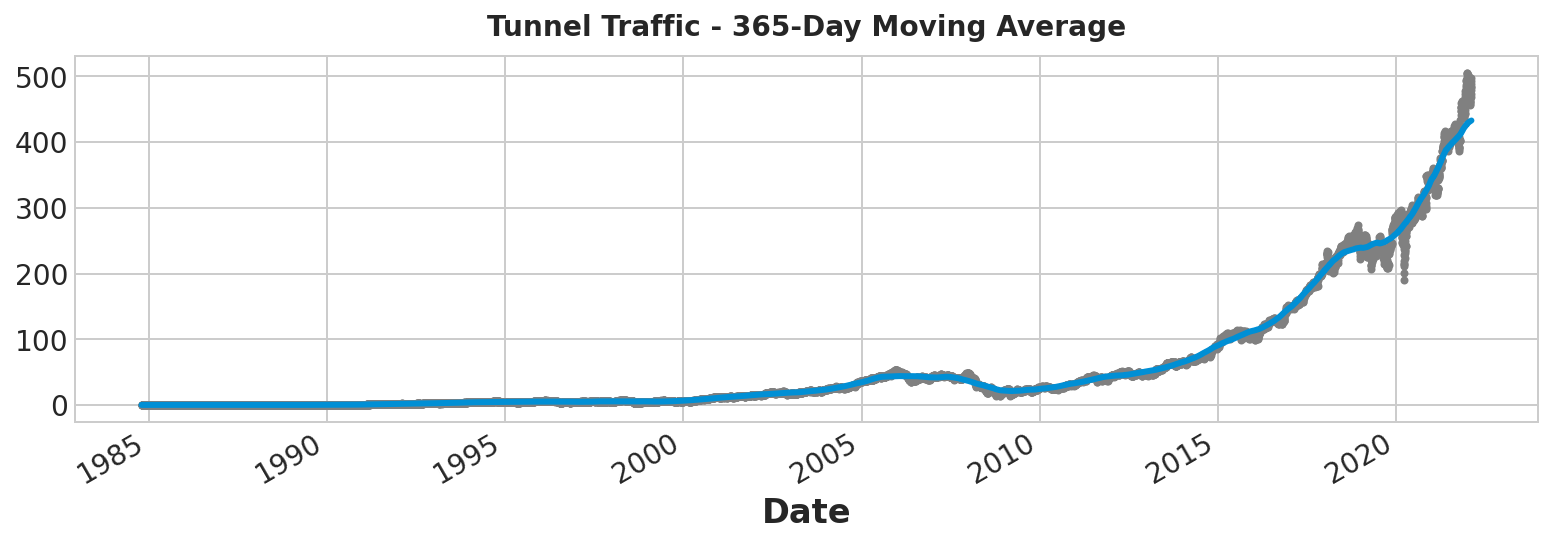

In [12]:
moving_average = stock_data['Close'].rolling(
    window=365,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=183,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = stock_data['Close'].plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Tunnel Traffic - 365-Day Moving Average", legend=False,
)

In [13]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index=stock_data.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=1,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()

X.head()

,const,trend
Date,,
1984-10-17,1.0,1.0
1984-10-18,1.0,2.0
1984-10-19,1.0,3.0
1984-10-22,1.0,4.0
1984-10-23,1.0,5.0


In [14]:
from sklearn.linear_model import LinearRegression

y = stock_data["Close"]  # the target

# The intercept is the same as the `const` feature from
# DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

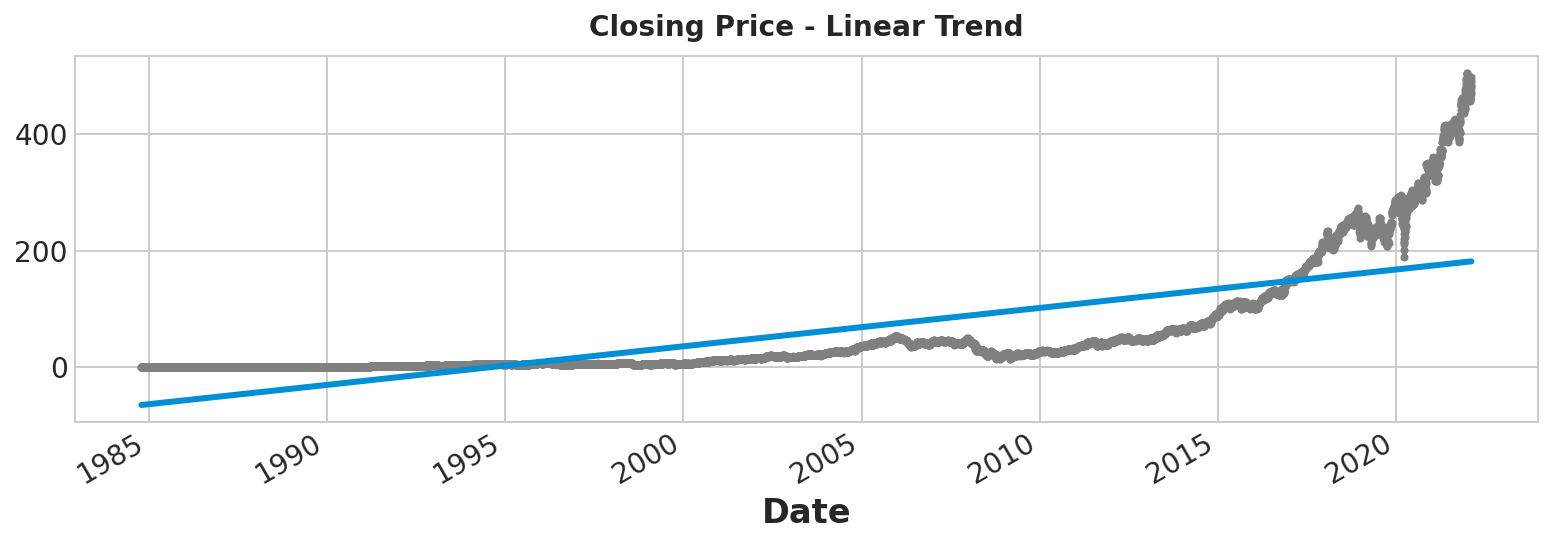

In [15]:

ax = stock_data["Close"].plot(style=".", color="0.5", title="Closing Price - Linear Trend")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")

In [16]:
X = dp.out_of_sample(steps=30)

y_fore = pd.Series(model.predict(X), index=X.index)

y_fore.head()

9407    181.595245
9408    181.621473
9409    181.647700
9410    181.673928
9411    181.700156
dtype: float64

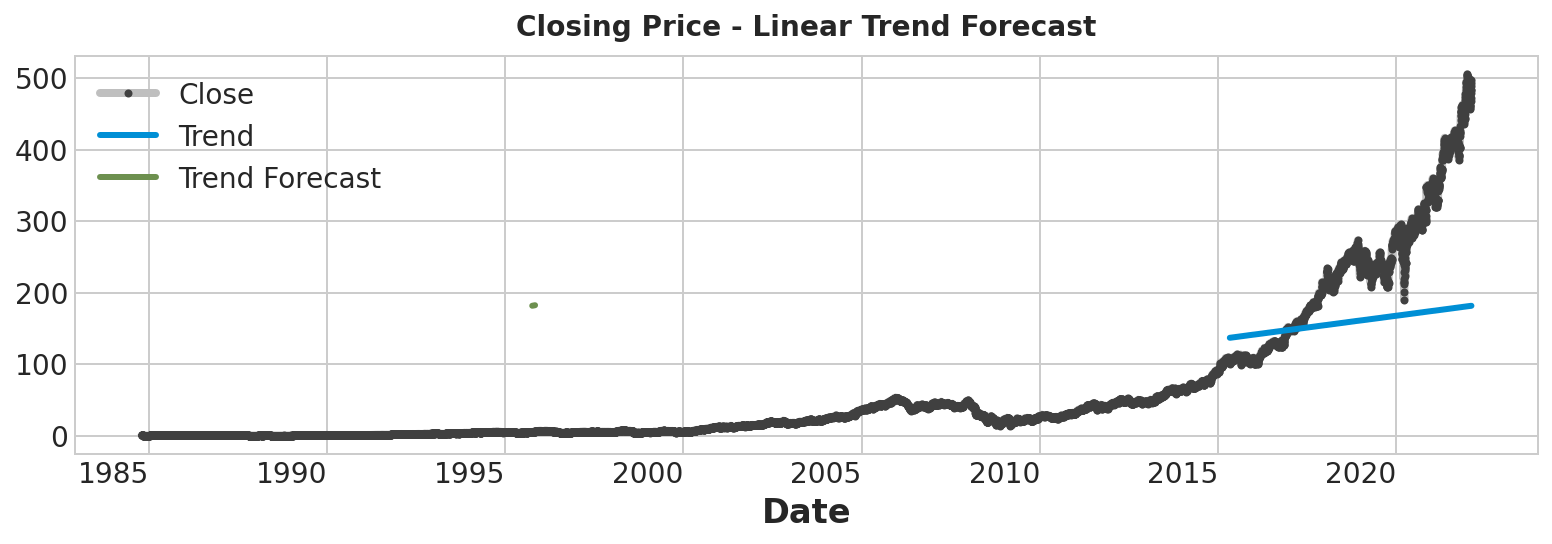

In [17]:
ax = stock_data['Close'].plot(title="Closing Price - Linear Trend Forecast", **plot_params)
ax = y_pred["2015-05":].plot(ax=ax, linewidth=3, label="Trend")
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3")
_ = ax.legend()

In [18]:
import numpy as np


def fourier_features(index, freq, order):
    time = np.arange(len(index), dtype=np.float32)
    k = 2 * np.pi * (1 / freq) * time
    features = {}
    for i in range(1, order + 1):
        features.update({
            f"sin_{freq}_{i}": np.sin(i * k),
            f"cos_{freq}_{i}": np.cos(i * k),
        })
    return pd.DataFrame(features, index=index)

In [19]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'


# annotations: https://stackoverflow.com/a/49238256/5769929
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

<AxesSubplot:title={'center':'Seasonal Plot (year/dayofyear)'}, xlabel='dayofyear', ylabel='Close'>

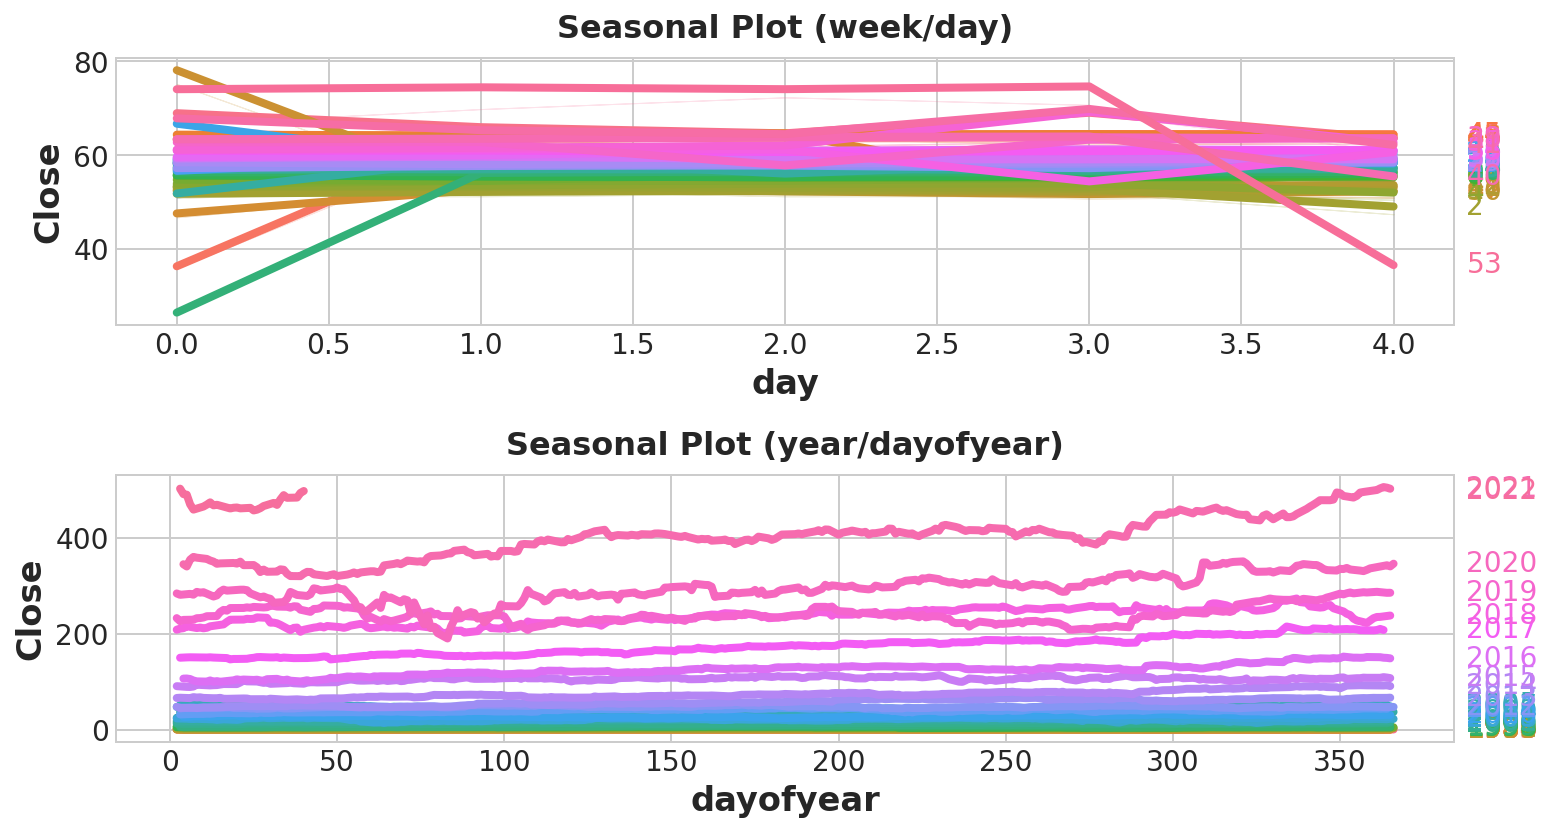

In [20]:
X = stock_data.copy()

# days within a week
X["day"] = X.index.dayofweek  # the x-axis (freq)
X["week"] = X.index.week  # the seasonal period (period)

# days within a year
X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(X, y="Close", period="week", freq="day", ax=ax0)
seasonal_plot(X, y="Close", period="year", freq="dayofyear", ax=ax1)

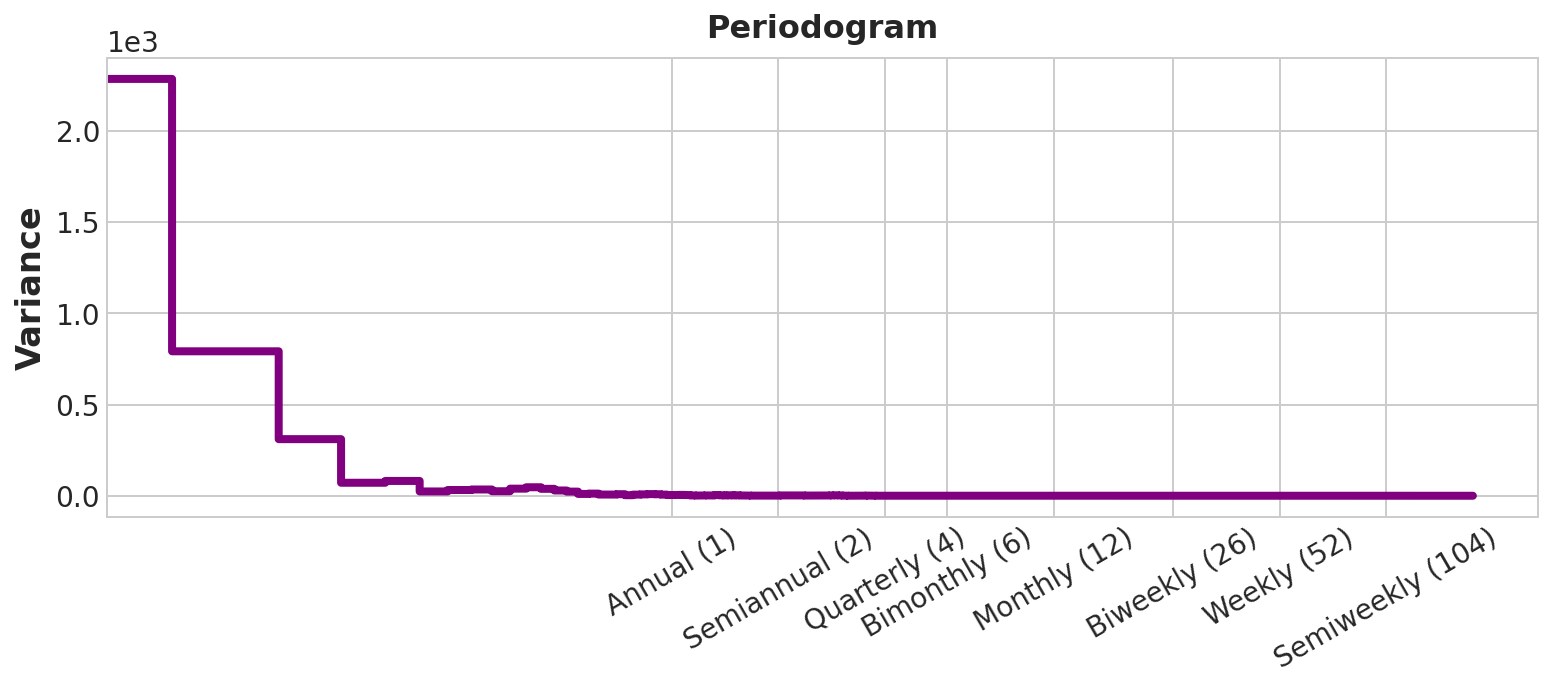

In [21]:
plot_periodogram(stock_data.Close);

In [22]:
stock_data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Time,Date,Lag_1
Date,,,,,,,,,,
1984-10-17,0.0,0.122685,0.119455,0.119455,9868800,0.0,0.0,0,1984-10-17,NaN
1984-10-18,0.0,0.129141,0.122685,0.122685,5324800,0.0,0.0,1,1984-10-18,0.119455
1984-10-19,0.0,0.122685,0.119455,0.119455,3043200,0.0,0.0,2,1984-10-19,0.122685
1984-10-22,0.0,0.122685,0.119455,0.119455,2326400,0.0,0.0,3,1984-10-22,0.119455
1984-10-23,0.0,0.119456,0.116227,0.116227,787200,0.0,0.0,4,1984-10-23,0.119455


In [23]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.signal import periodogram
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_pacf

simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'


def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig


In [24]:
stock_data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Time,Date,Lag_1
Date,,,,,,,,,,
1984-10-17,0.0,0.122685,0.119455,0.119455,9868800,0.0,0.0,0,1984-10-17,NaN
1984-10-18,0.0,0.129141,0.122685,0.122685,5324800,0.0,0.0,1,1984-10-18,0.119455
1984-10-19,0.0,0.122685,0.119455,0.119455,3043200,0.0,0.0,2,1984-10-19,0.122685
1984-10-22,0.0,0.122685,0.119455,0.119455,2326400,0.0,0.0,3,1984-10-22,0.119455
1984-10-23,0.0,0.119456,0.116227,0.116227,787200,0.0,0.0,4,1984-10-23,0.119455


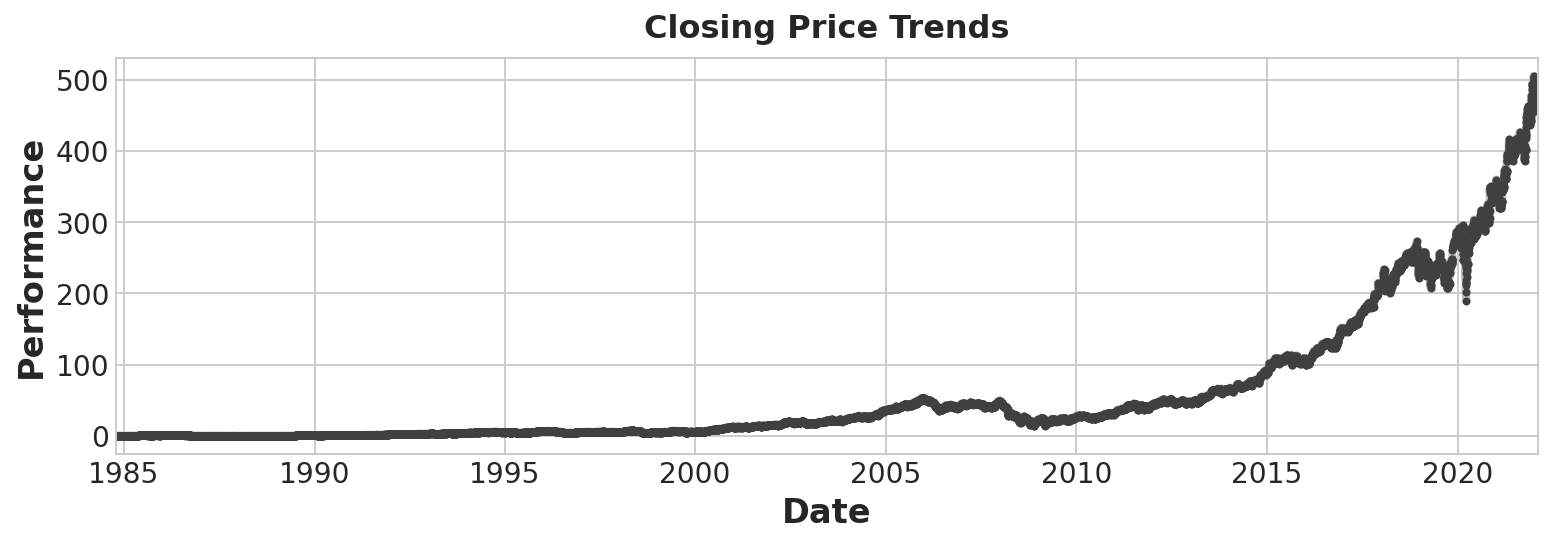

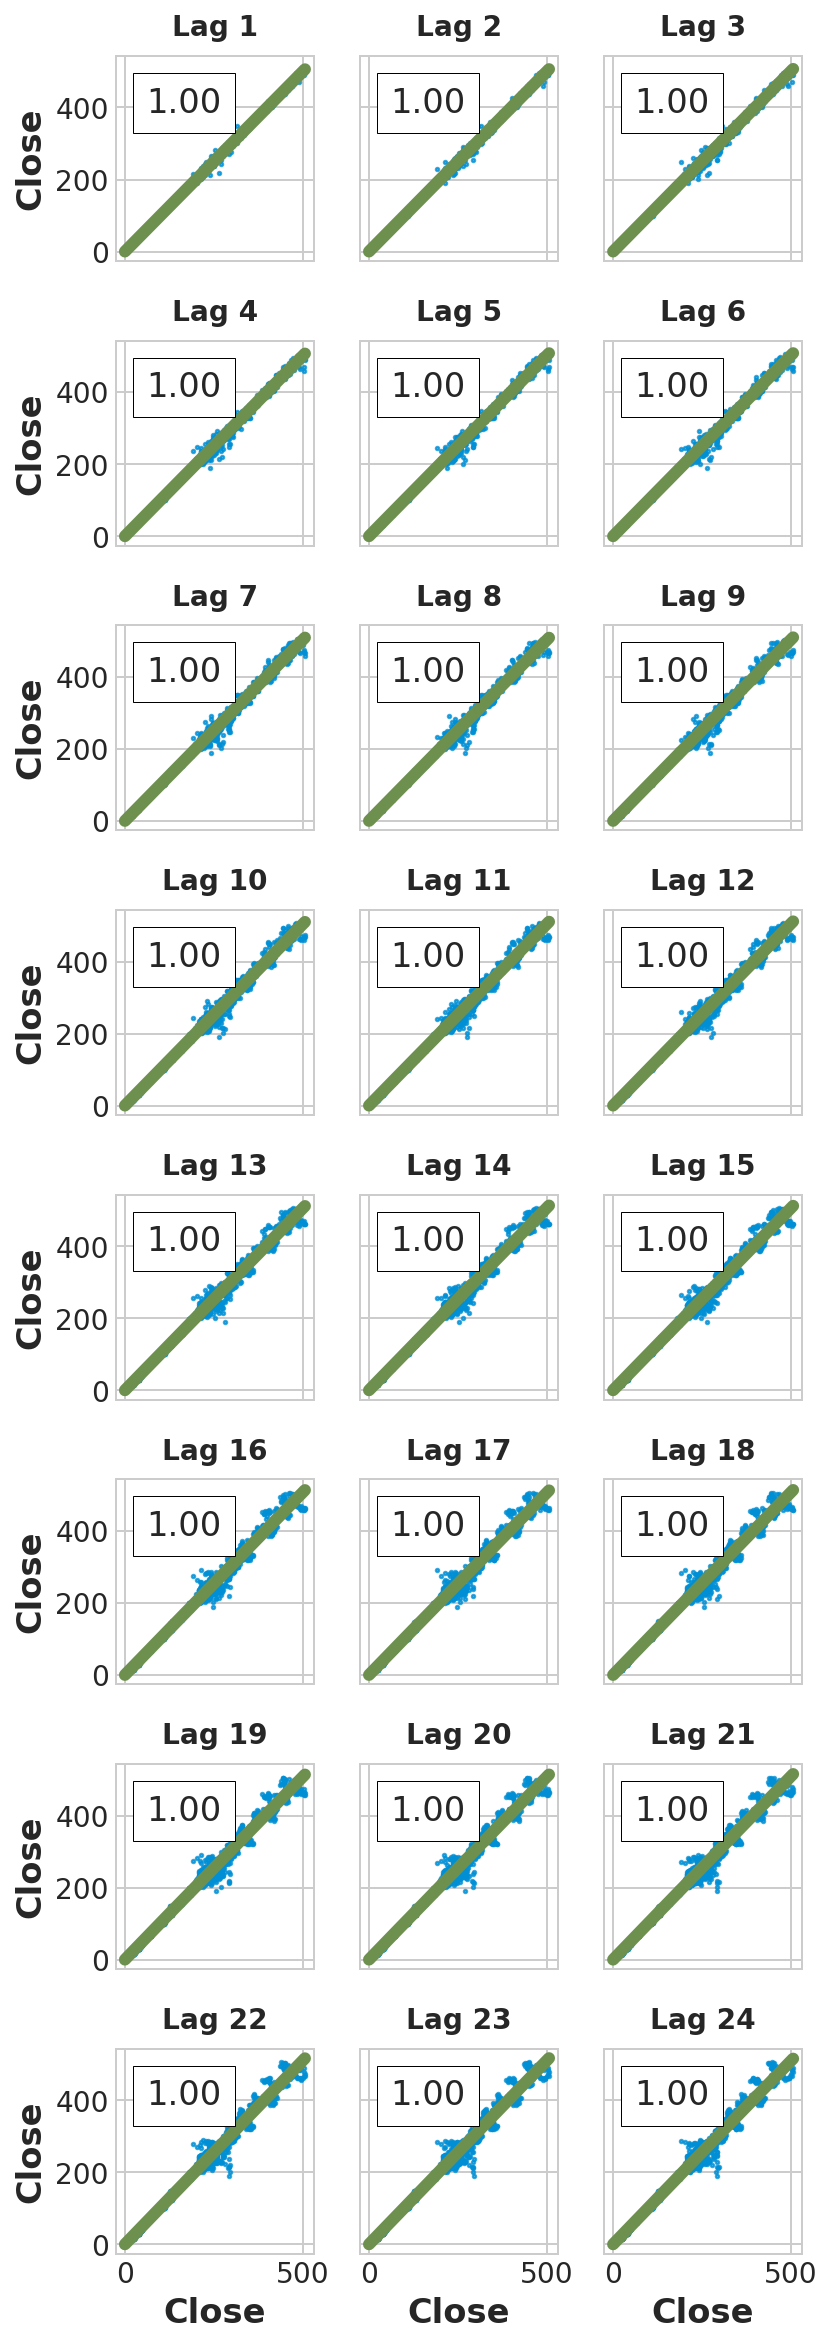

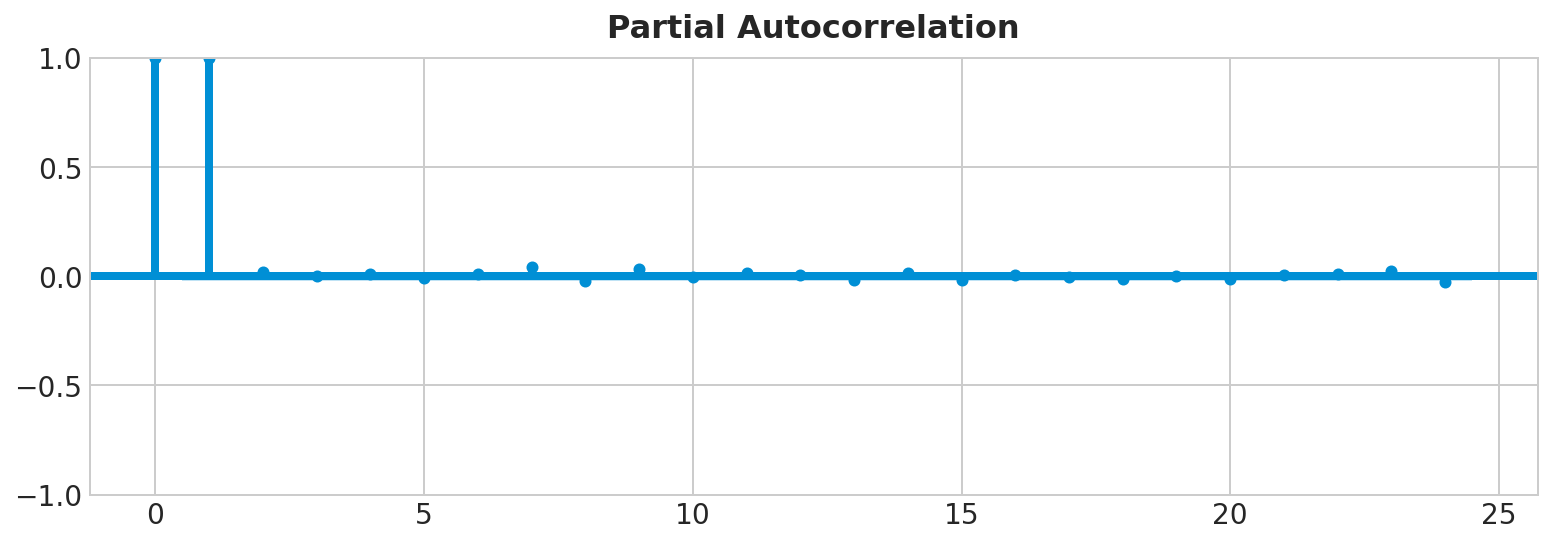

In [25]:
X = stock_data.copy()

# days within a week
#X["Week"] = X.Date.Week  # the seasonal period (period)

# days within a year
#X["dayofyear"] = X.Date.dayofyear
#X["year"] = X.Date.year

X.set_index(
    pd.PeriodIndex(X.Date, freq="W"),
    inplace=True,
)
#X.drop("Week", axis=1, inplace=True)

ax = X.Close.plot(title='Closing Price Trends', **plot_params)
_ = ax.set(ylabel="Performance")

_ = plot_lags(X.Close, lags=24, nrows=8)
_ = plot_pacf(X.Close, lags=24)

Also, a given time series is thought to consist of three systematic components including level, trend, seasonality, and one non-systematic component called noise.

These components are defined as follows:

1. **Level**: The average value in the series.

2. **Trend**: The increasing or decreasing value in the series.

3. **Seasonality**: The repeating short-term cycle in the series.

4. **Noise**: The random variation in the series.

First, we need to check if a series is stationary or not because time series analysis only works with stationary data.


**ADF (Augmented Dickey-Fuller) Test**

The Dickey-Fuller test is one of the most popular statistical tests. It can be used to determine the presence of unit root in the series, and hence help us understand if the series is stationary or not. The null and alternate hypothesis of this test is:


**Null Hypothesis**: The series has a unit root (value of a =1)


**Alternate Hypothesis**: The series has no unit root.


If we fail to reject the null hypothesis, we can say that the series is non-stationary. This means that the series can be linear or difference stationary.


If both mean and standard deviation are flat lines(constant mean and constant variance), the series becomes stationary.


**So let's check for stationarity:

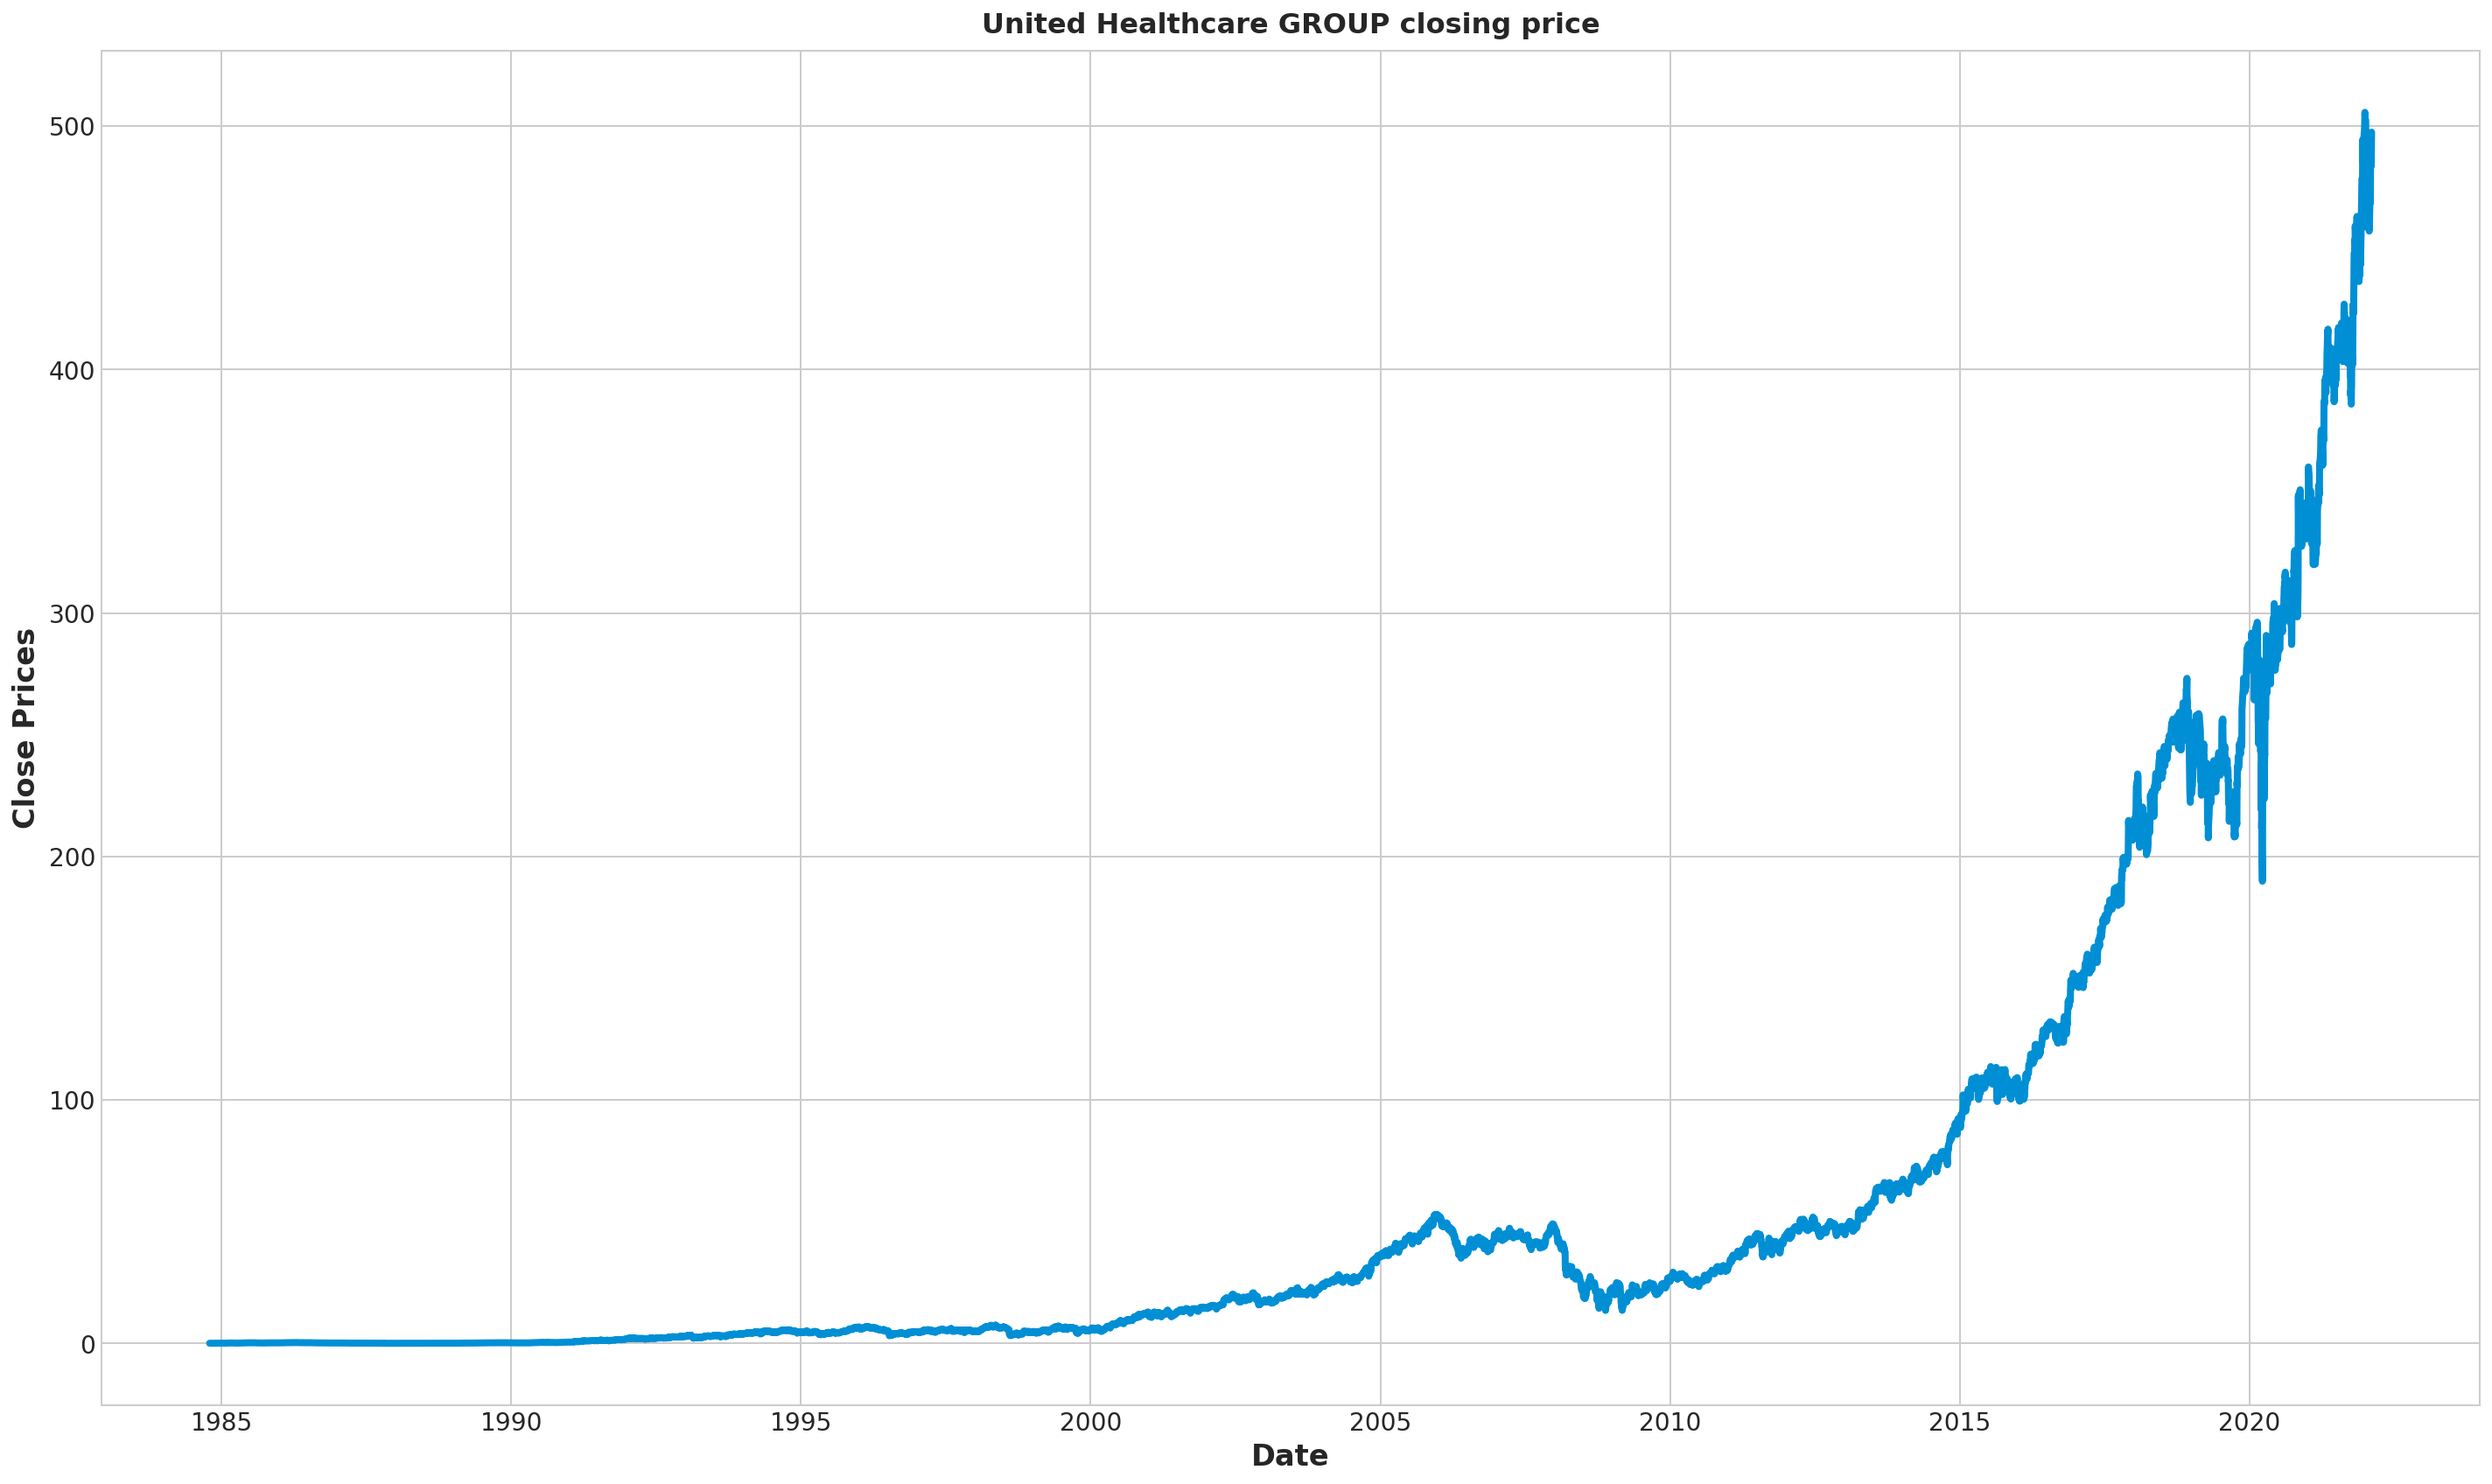

In [26]:
#plot close price
plt.figure(figsize=(20,12))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['Close'])
plt.title('United Healthcare GROUP closing price')
plt.show()

<AxesSubplot:ylabel='Density'>

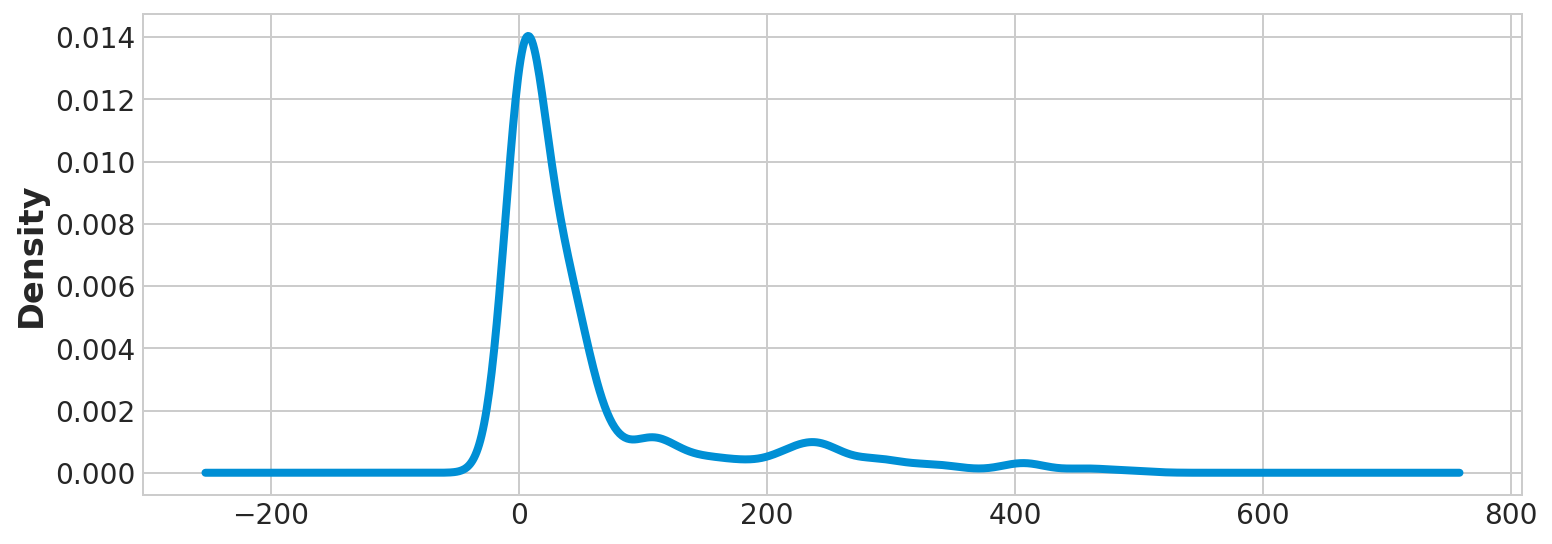

In [27]:
stock_data.Close.plot(kind='kde')


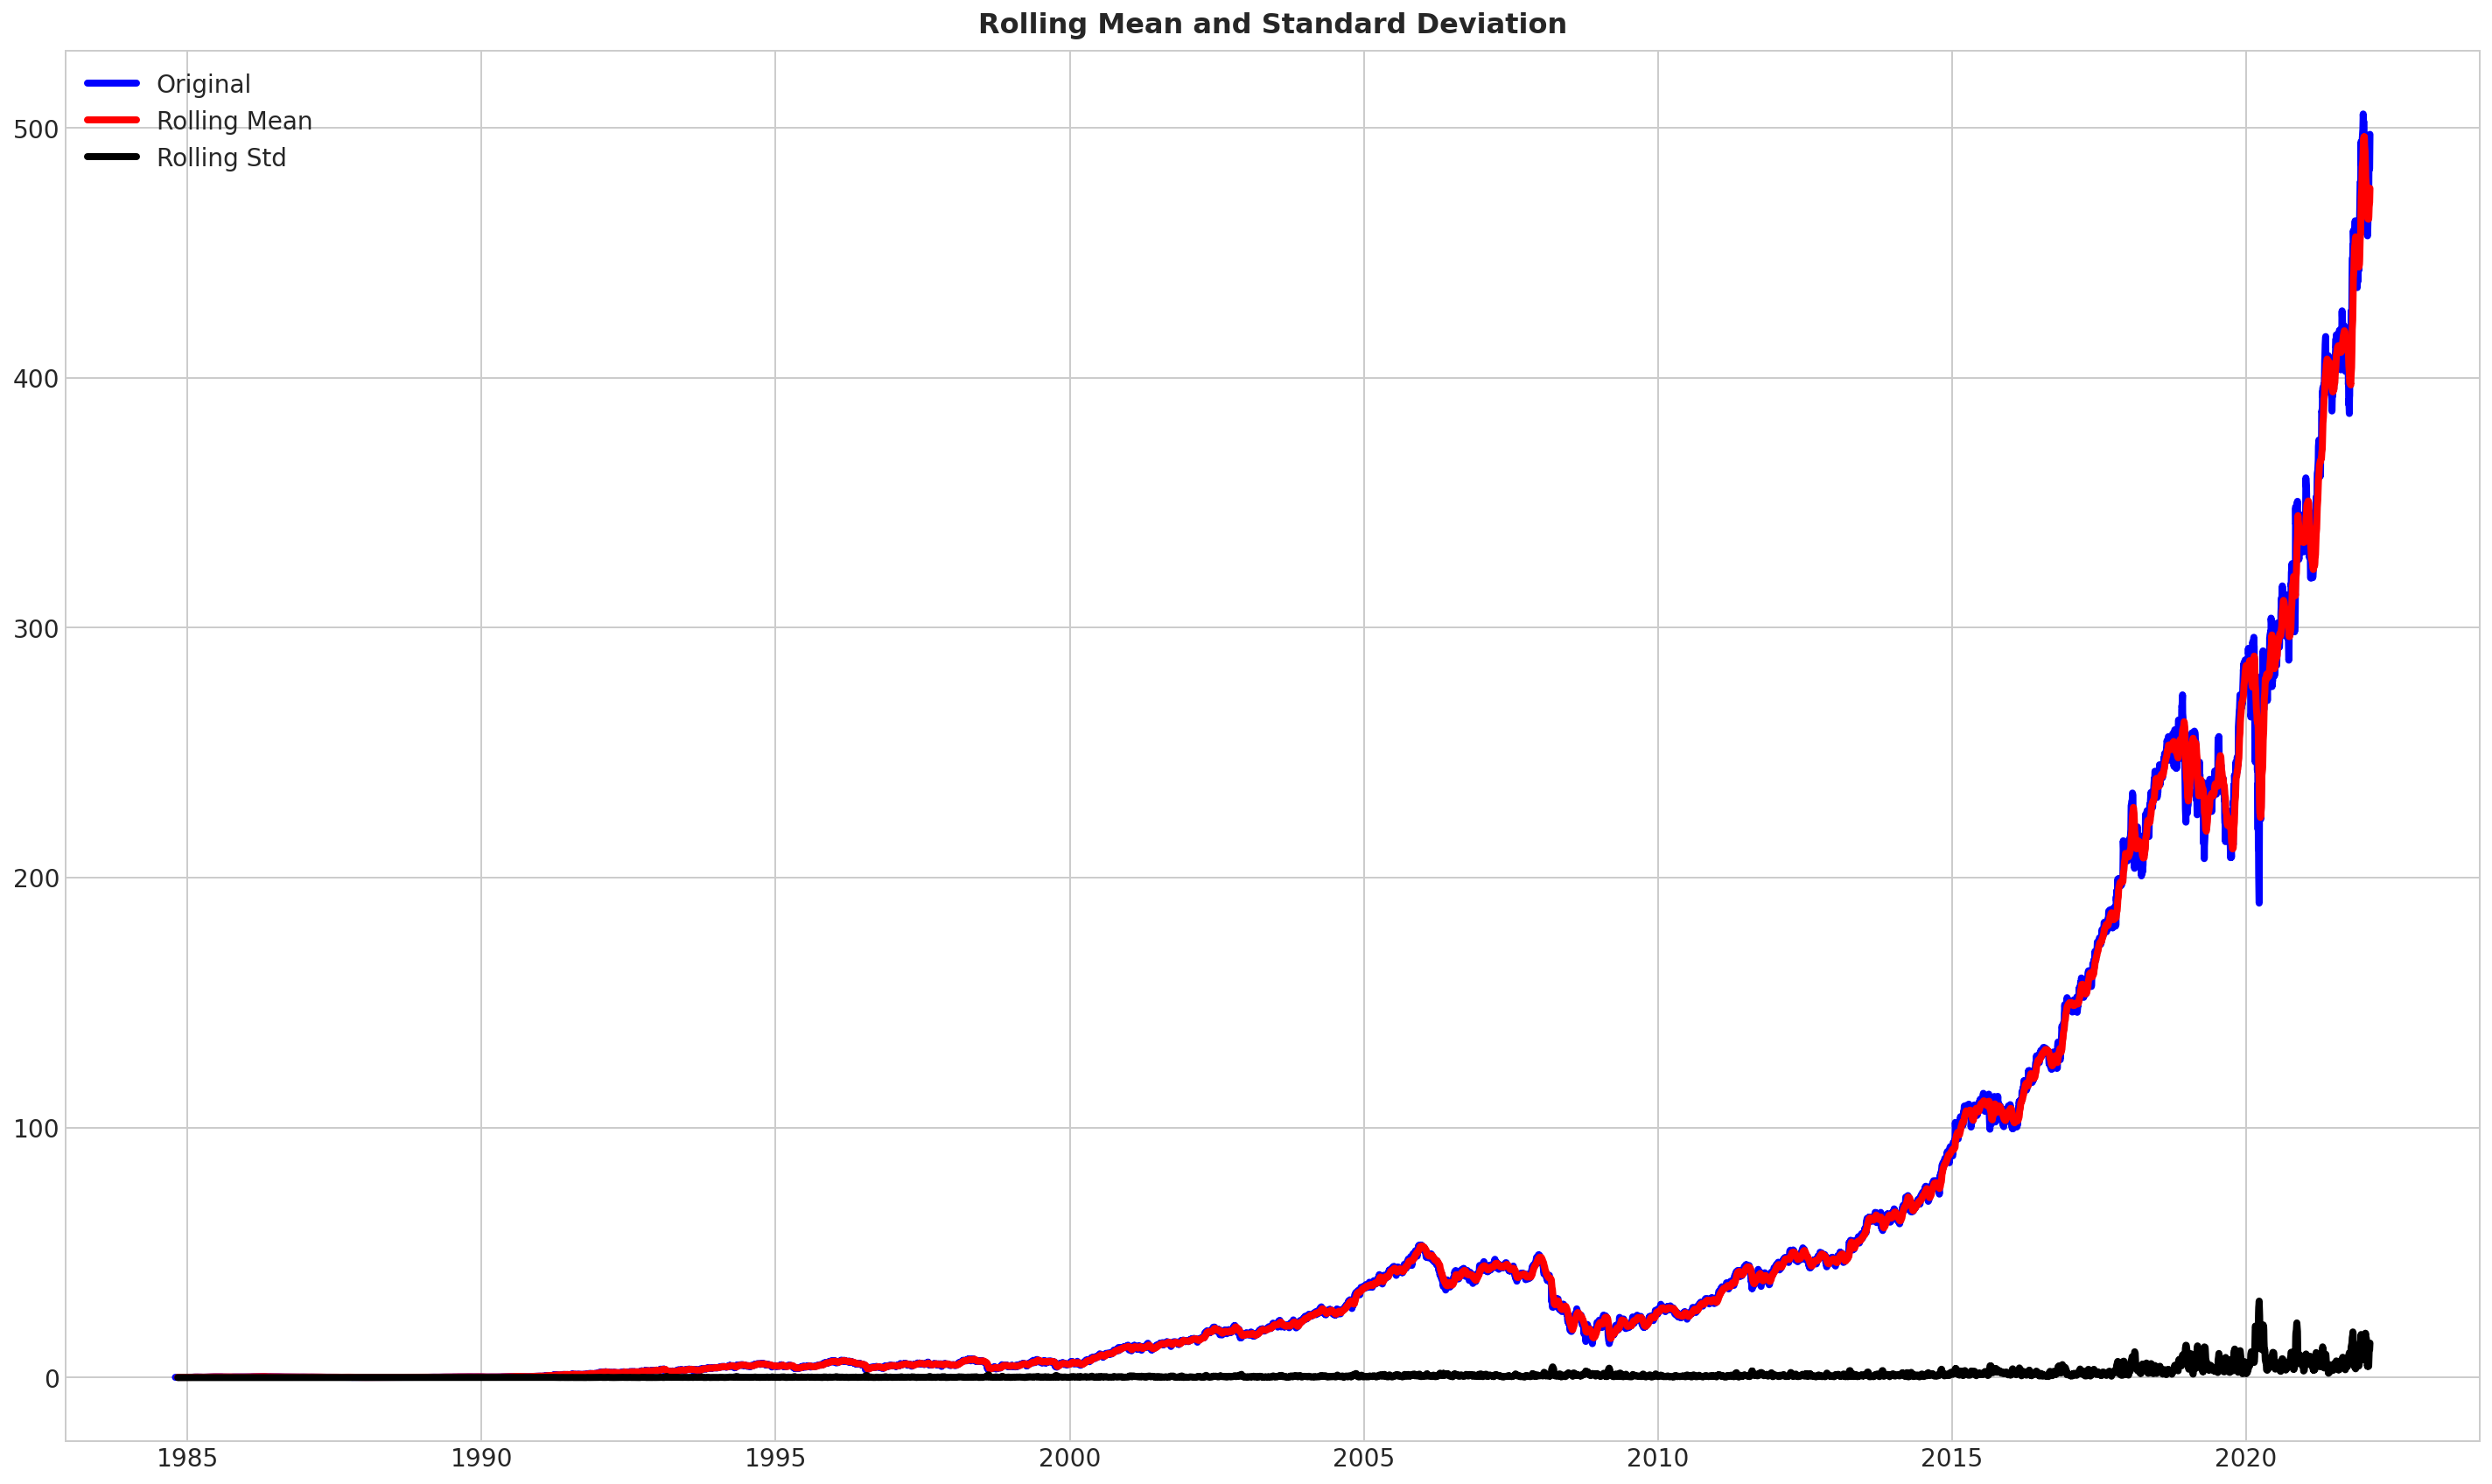

Results of dickey fuller test
Test Statistics                   7.050767
p-value                           1.000000
No. of lags used                 37.000000
Number of observations used    9368.000000
critical value (1%)              -3.431048
critical value (5%)              -2.861849
critical value (10%)             -2.566934
dtype: float64


In [28]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.figure(figsize=(20,12))
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(stock_data.Close)

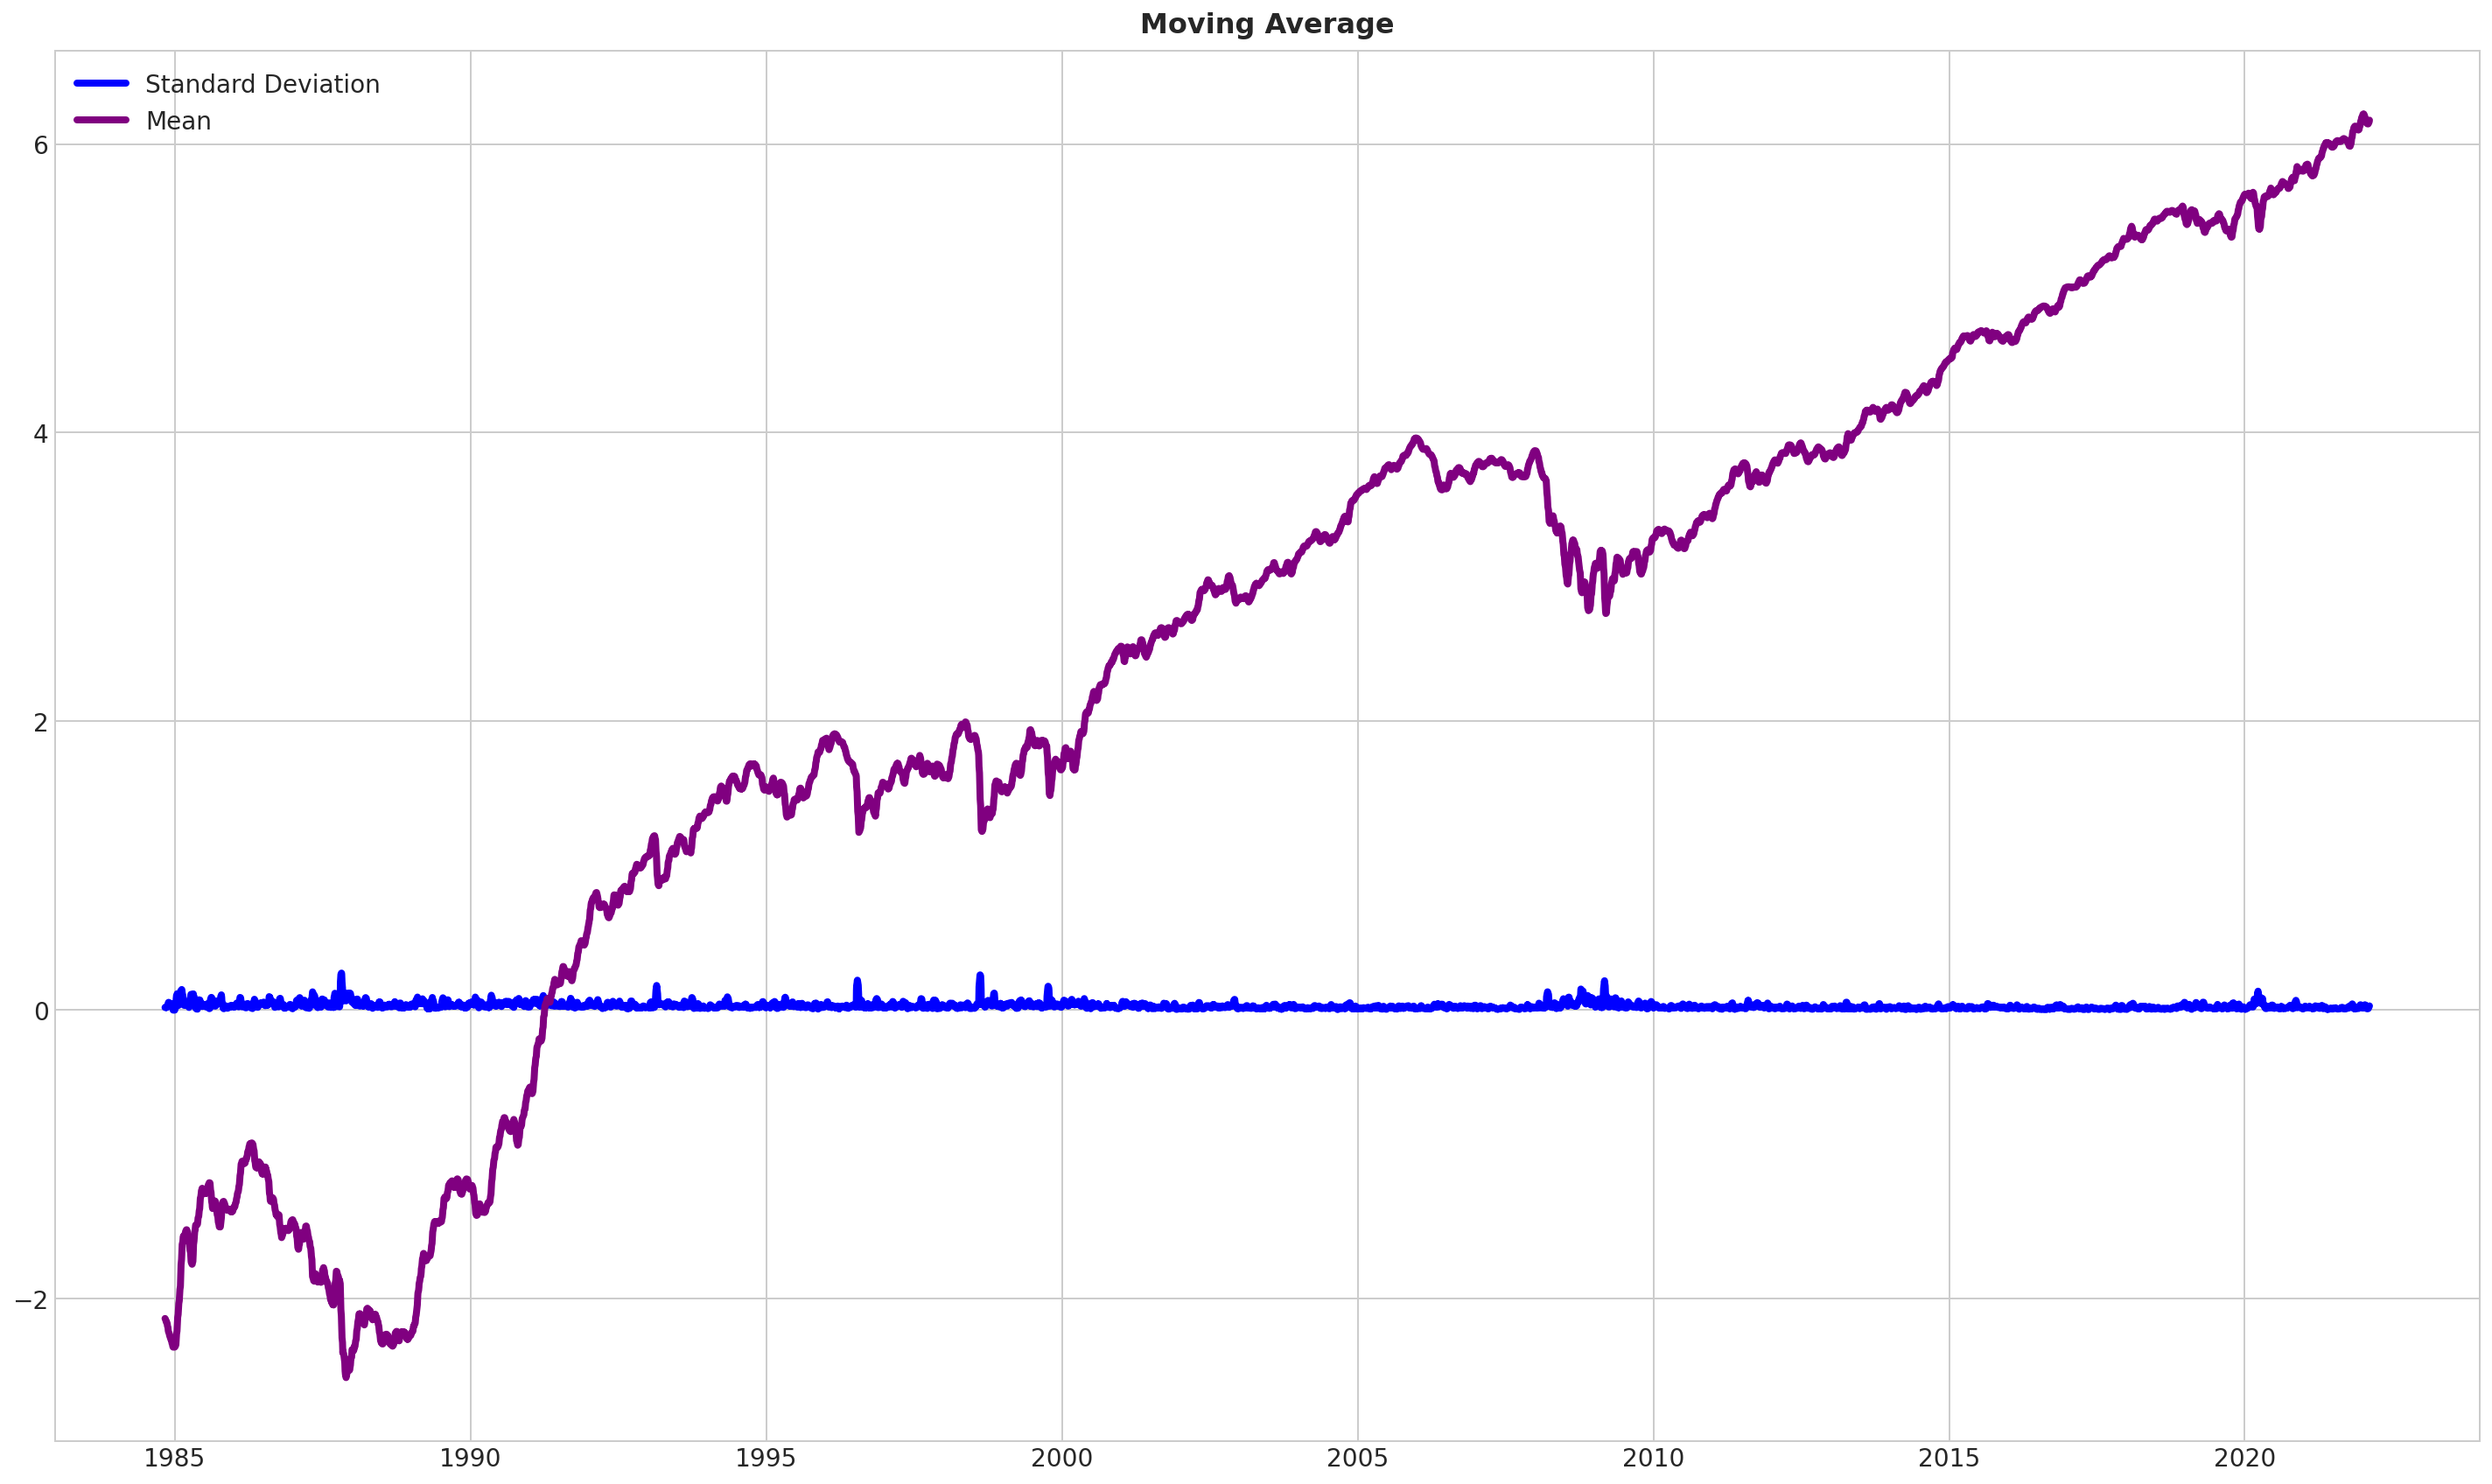

In [29]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 20, 12
df_log = np.log(stock_data.Close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="blue", label = "Standard Deviation")
plt.plot(moving_avg, color="purple", label = "Mean")
plt.legend()
plt.show()

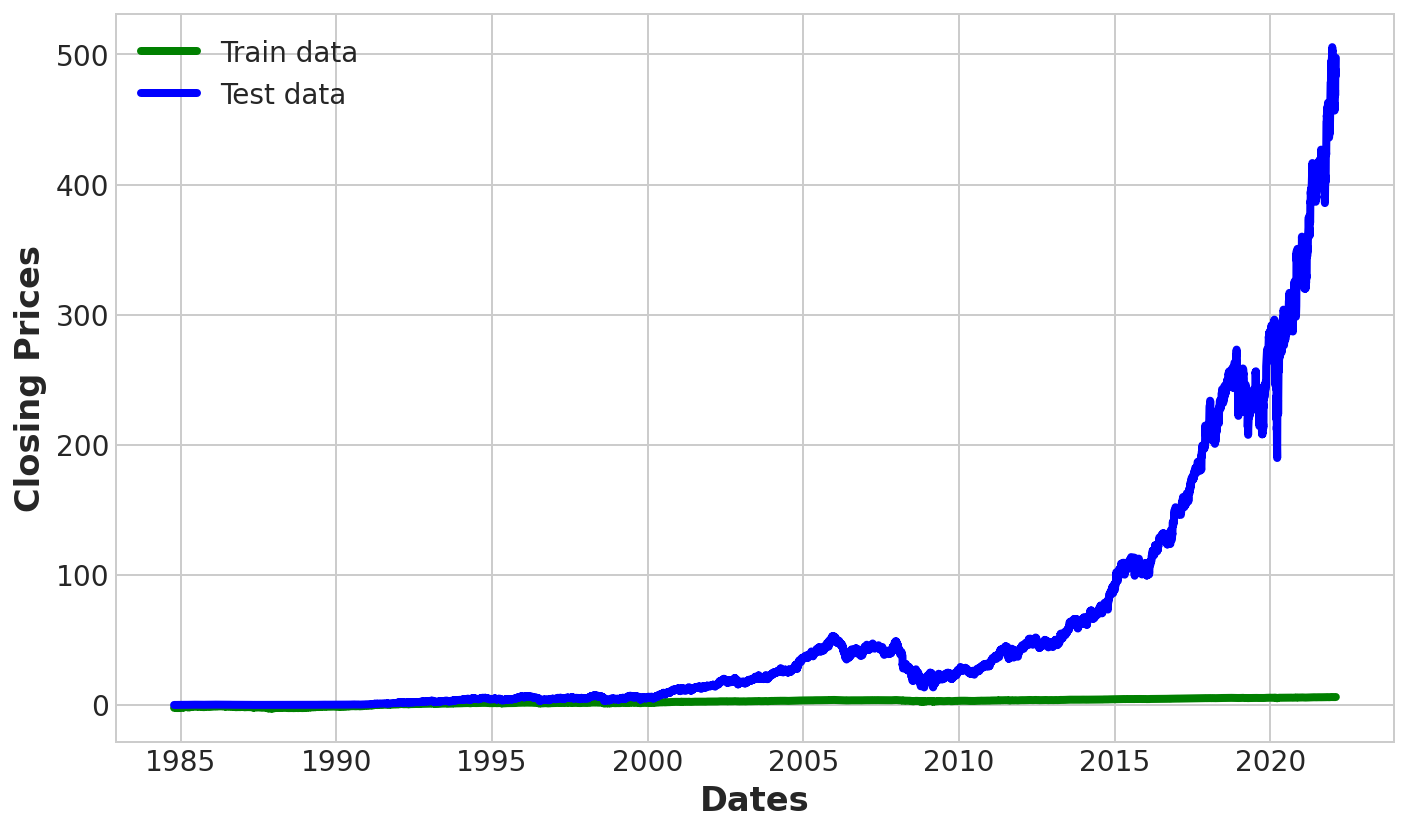

In [30]:

#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(stock_data.Close, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=38384.774, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=38325.302, Time=0.50 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=38336.757, Time=0.78 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=38390.358, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=38200.731, Time=0.85 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=38179.905, Time=1.73 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=38144.440, Time=9.21 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=38191.357, Time=1.79 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=37846.840, Time=12.50 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=37896.902, Time=12.64 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=37888.763, Time=22.92 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=37845.108, Time=14.90 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=38186.841, Time=8.69 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=38176.513, Time=1.77 sec
 ARIMA(2,1,3)(0

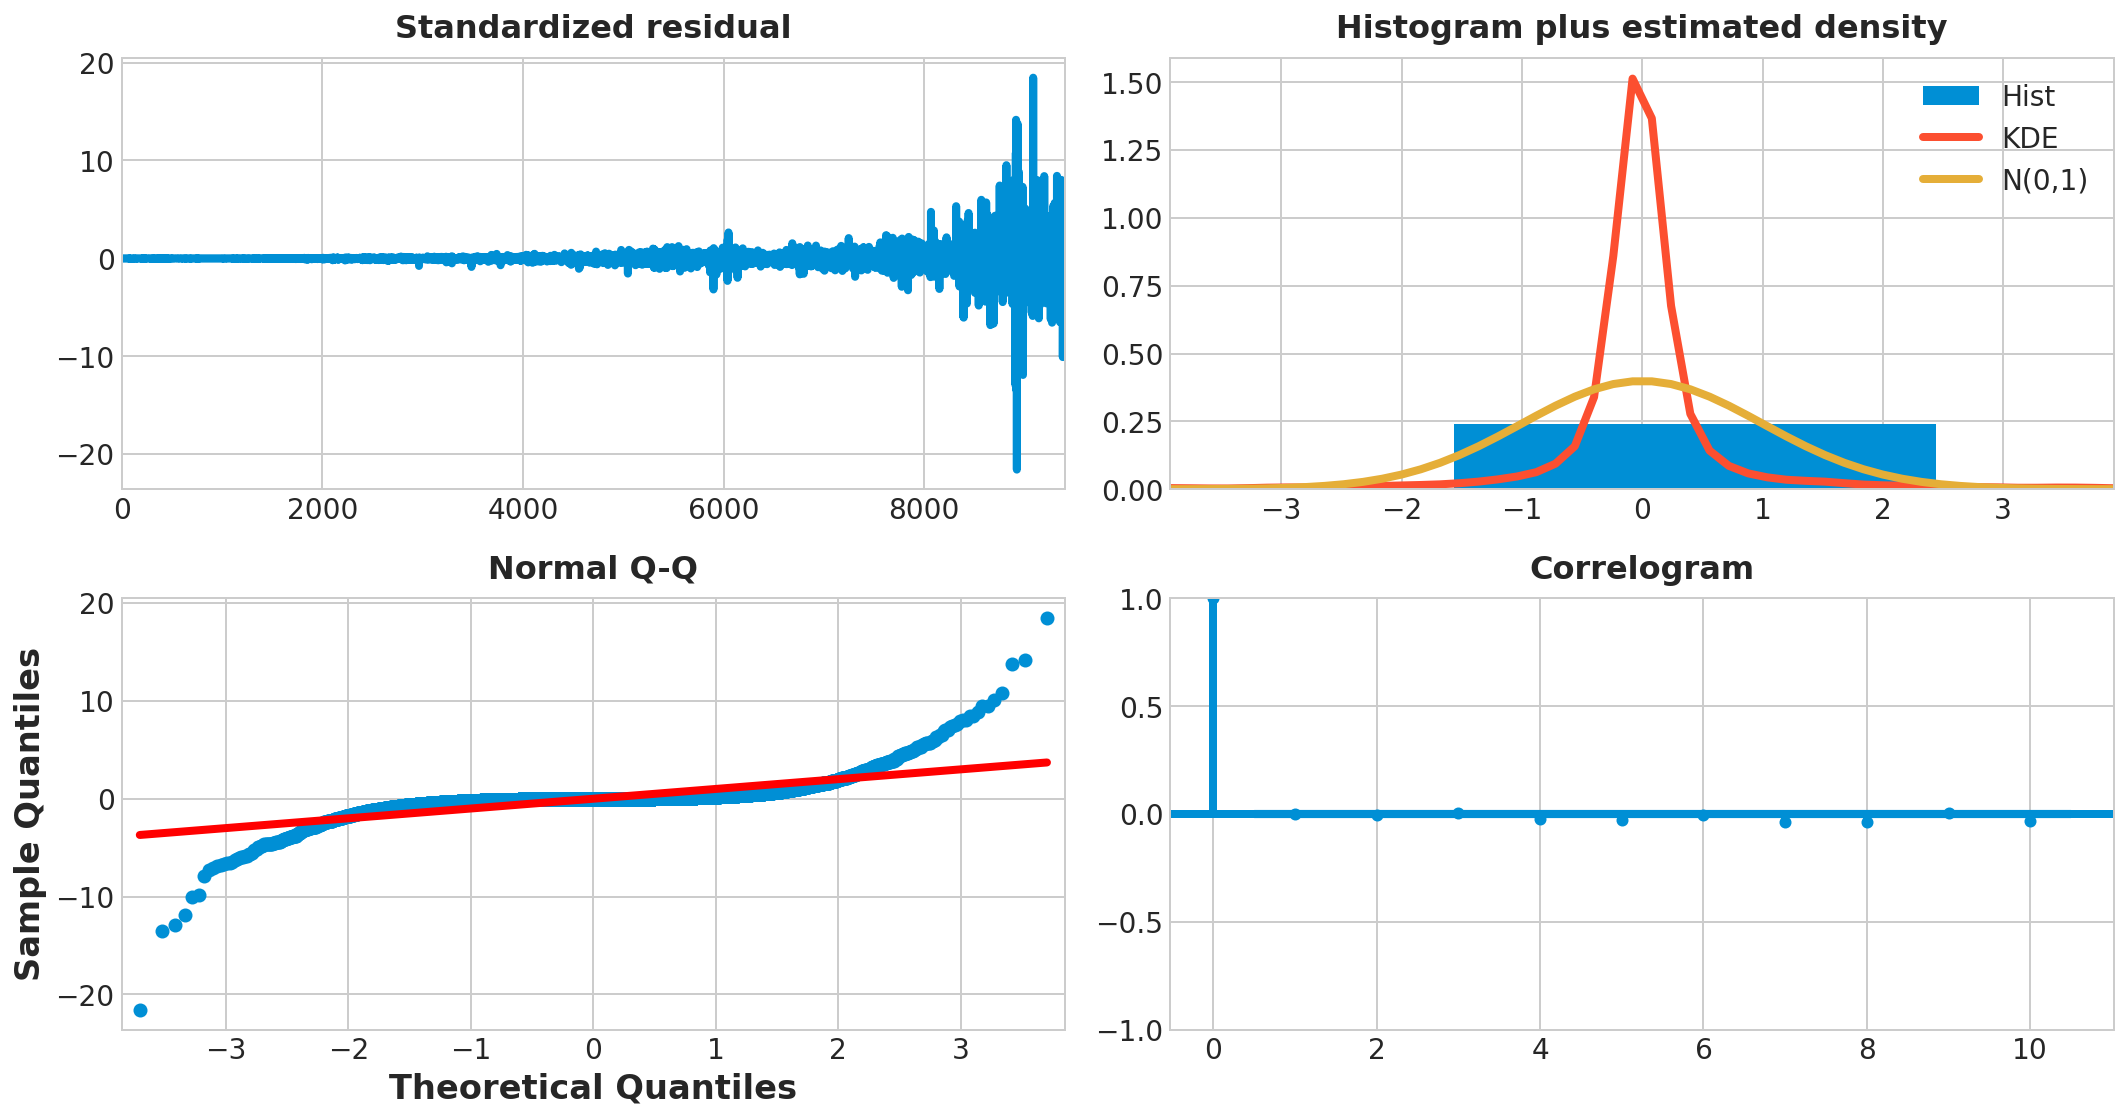

In [31]:
model_autoARIMA = auto_arima(stock_data.Close, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

## Plot Interpertation


**Top left**: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.


**Top Right**: The density plot suggest normal distribution with mean zero.


**Bottom left**: All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.


**Bottom Right**: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model.

# Work In Progress 